In [56]:
# vocab building
import os
import csv
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

folder_path = 'proccessed_data/'
train = open('./data/train.csv', 'r', encoding='utf-8-sig')
test = open('./data/test.csv', 'r', encoding='utf-8-sig')
files = os.listdir(folder_path)

# 四大分類
dict = {"浪漫派":1, "山水田園派":2, "社會寫實派":3, "邊塞派":4}
# 建立 tokenizer 
tokenizer = get_tokenizer("basic_english")

def yield_tokens(folder_path):
    for file in files:
        file_path = os.path.join(folder_path, file)
        # print(file[:-4])
        with open(file_path, 'r', encoding = 'utf-8-sig') as f:
            csvreader = csv.reader(f)
            for row in csvreader:
                for char in row[0]:
                    # vocab building
                    yield tokenizer(char)

vocab = build_vocab_from_iterator(yield_tokens(folder_path), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1


In [57]:
# dataset building
import pandas as pd
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # data: {label, text}
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        label = sample.iloc[0]
        text = sample.iloc[1]
        if self.transform:
            label = self.transform(label)
            text = self.transform(text)
        return label, text

def transform(sample):
    return sample

test_file = './data/test.csv'
train_file = './data/train.csv'

train_dataset = CustomDataset(train_file, transform=transform)
test_dataset = CustomDataset(test_file, transform=transform)

In [58]:
import torch
from torch.utils.data import DataLoader
from torch import nn

# Generate data batch and iterato
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# model define
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
num_class = 4
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [60]:
import time

EPOCHS = 10 
LR = 5  # learning rate
BATCH_SIZE = 64  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

def train(dataloader, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 400
    start_time = time.time()
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

cross valid score

In [61]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
total = 0
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, epoch)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    total+=accu_val
    print("-" * 45)
    print(
        "| end of epoch {:3d} | valid accuracy {:8.3f} |".format(epoch, accu_val)
    )
print("-" * 45)
print("The mean of valid accuracy ", total/10)

---------------------------------------------
| end of epoch   1 | valid accuracy    0.448 |
---------------------------------------------
| end of epoch   2 | valid accuracy    0.511 |
---------------------------------------------
| end of epoch   3 | valid accuracy    0.522 |
---------------------------------------------
| end of epoch   4 | valid accuracy    0.527 |
---------------------------------------------
| end of epoch   5 | valid accuracy    0.507 |
---------------------------------------------
| end of epoch   6 | valid accuracy    0.514 |
---------------------------------------------
| end of epoch   7 | valid accuracy    0.517 |
---------------------------------------------
| end of epoch   8 | valid accuracy    0.517 |
---------------------------------------------
| end of epoch   9 | valid accuracy    0.517 |
---------------------------------------------
| end of epoch  10 | valid accuracy    0.517 |
---------------------------------------------
The mean of valid accura

[[426  67 126  57]
 [ 95 148 165  44]
 [122  72 693  80]
 [ 59  34 125 103]]


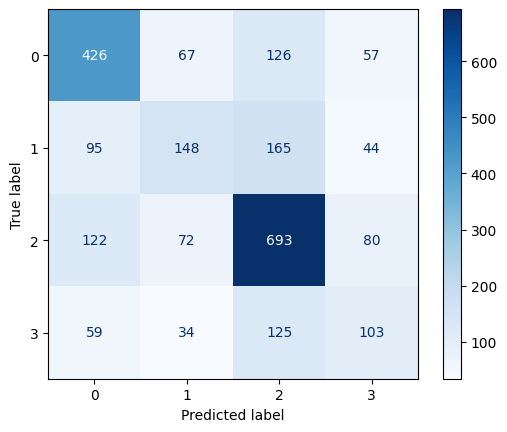

In [68]:
import json
import io
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix(dataloader):
    confusion_matrix = np.zeros((4, 4), dtype=np.int64)
    model.eval()
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            
            for i in range(label.shape[0]):
                confusion_matrix[label[i], predicted_label.argmax(1)[i]] +=1
    return confusion_matrix

print(confusion_matrix(test_dataloader))
display = ConfusionMatrixDisplay(confusion_matrix(test_dataloader)).plot(cmap='Blues')


In [69]:

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


num_dict = {1:"浪漫派", 2:"山水田園派", 3:"社會寫實派", 4:"邊塞派"}

item = "春眠不覺曉，處處聞啼鳥。夜來風雨聲，花落知多少。"
item_ = ' '.join(item)
# print(item_)

model = model.to("cpu")

print("詩句 <%s> \n來自%s" % (item, num_dict[predict(item_, text_pipeline)]))
print("詩句 <%s> \n來自%s" % (item, predict(item_, text_pipeline)))


詩句 <春眠不覺曉，處處聞啼鳥。夜來風雨聲，花落知多少。> 
來自邊塞派
詩句 <春眠不覺曉，處處聞啼鳥。夜來風雨聲，花落知多少。> 
來自4


In [70]:
torch.save(model, 'product_classifier_1.pt')